In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## 0. Install IPD package 
Note: Also installs notebook packages for running demos. Omit the optional `notebooks` group if you don't want this.
### Option 1 (from source):
1. Clone this github repo
2. Run `pip install -e .[notebooks]` 
    1. Make sure you are using a compatible python version (tested with 3.9.2 and 3.10.14)
    2. Recommend using a venv

### Option 2 (not available yet):
1. `pip install intrinsic-ipd[notebooks]`

### Option 3:
1. `pip install git+[github/http/url]@main[notebooks]`

## 1. Imports

In [3]:
from intrinsic_ipd import IPDReader, IPDCamera, IPDImage, IPDLightCondition
import intrinsic_ipd.constants # import CameraFramework, DATASET_IDS
import os
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
np.set_printoptions(precision=4, suppress=True)

In [4]:
import logging
logging.basicConfig(
    level=logging.INFO,  # Set the logging level (INFO, DEBUG, WARNING, etc.)
    format="%(asctime)s - %(name)s - %(levelname)s - %(filename)s - %(funcName)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)

## 2. Download (if not exists) and load dataset

### 2.1 Select a dataset among list of dataset ids.

In [5]:
dataset_id = intrinsic_ipd.constants.DATASET_IDS[20]
intrinsic_ipd.constants.DATASET_IDS

['dataset_basket_0',
 'dataset_basket_1',
 'dataset_basket_2',
 'dataset_basket_3',
 'dataset_basket_4',
 'dataset_basket_5',
 'dataset_basket_6',
 'dataset_basket_7',
 'dataset_basket_8',
 'dataset_basket_9',
 'dataset_darkbg_0',
 'dataset_darkbg_1',
 'dataset_darkbg_2',
 'dataset_darkbg_3',
 'dataset_darkbg_4',
 'dataset_darkbg_5',
 'dataset_darkbg_6',
 'dataset_darkbg_7',
 'dataset_darkbg_8',
 'dataset_texturedbg_0',
 'dataset_texturedbg_1',
 'dataset_texturedbg_2',
 'dataset_texturedbg_3']

### 2.2 Select camera and lighting condition
See `intrinsic_ipd.constants` for available options

In [6]:
camera = intrinsic_ipd.constants.IPDCamera.PHOTONEO
lighting = intrinsic_ipd.constants.IPDLightCondition.ROOM 
dataset_id

'dataset_texturedbg_1'

### 2.3 Read dataset (optionally, download)

The `download` option allows you to download the dataset if it does not exist, otherwise this class will read in the dataset from the root path specified.

In [7]:
ipd_reader = IPDReader("./datasets", dataset_id=dataset_id, camera=camera, lighting=lighting, download=True) 

corner_bracket2_symm.json: 0.00B [00:00, ?B/s]

corner_bracket2_symm.json: 0.00B [00:00, ?B/s]
2024-09-21 00:09:19 - root - ERROR - utils.py - download - url: https://storage.googleapis.com/akasha-public/industrial_plenoptic_dataset/cad_models/symmetries/corner_bracket2_symm.json failed to download with error: HTTP Error 404: Not Found
corner_bracket5.stl: 0.00B [00:00, ?B/s]
2024-09-21 00:09:19 - root - ERROR - utils.py - download - url: https://storage.googleapis.com/akasha-public/industrial_plenoptic_dataset/cad_models/corner_bracket5.stl failed to download with error: HTTP Error 404: Not Found
corner_bracket5_symm.json: 0.00B [00:00, ?B/s]
2024-09-21 00:09:19 - root - ERROR - utils.py - download - url: https://storage.googleapis.com/akasha-public/industrial_plenoptic_dataset/cad_models/symmetries/corner_bracket5_symm.json failed to download with error: HTTP Error 404: Not Found
handrail_bracket_symm.json: 0.00B [00:00, ?B/s]
2024-09-21 00:09:20 - root - ERROR - utils.py - download - url: https://storage.googleapis.com/akasha-pub

## 3. Examples of reading data

### 3.1 Getting a list of available parts and object instances

In [8]:
ipd_reader.parts

{'corner_bracket0',
 'corner_bracket6',
 'gear1',
 'handrail_bracket',
 'wraparound_bracket'}

In [9]:
# Objects are identified by part and instance.
ipd_reader.objects

[('corner_bracket0', 0),
 ('corner_bracket0', 1),
 ('corner_bracket0', 2),
 ('corner_bracket0', 3),
 ('corner_bracket0', 4),
 ('corner_bracket6', 0),
 ('corner_bracket6', 1),
 ('corner_bracket6', 2),
 ('corner_bracket6', 3),
 ('corner_bracket6', 4),
 ('gear1', 0),
 ('gear1', 1),
 ('gear1', 2),
 ('gear1', 3),
 ('handrail_bracket', 0),
 ('handrail_bracket', 1),
 ('handrail_bracket', 2),
 ('handrail_bracket', 3),
 ('handrail_bracket', 4),
 ('wraparound_bracket', 0),
 ('wraparound_bracket', 1),
 ('wraparound_bracket', 2),
 ('wraparound_bracket', 3)]

### 3.2 Getting ground truth pose annotations

Poses are stored as a Xarray DataArray with 4 dimensions, with the following coordinates: 
- `scene`: scene id integers in `reader.scenes.keys()`
- `object` (pandas multi-index) 
   - `part`: part names in `reader.parts`
   - `instance`: indicates which instance when there are multiple parts
- `transform_major`: [0, 1, 2, 3]
- `transform_minor`: [0, 1, 2, 3] 

Poses can be accessed by specifying the dimension and coordinate value.

See [Xarray Tutorials](https://tutorial.xarray.dev/fundamentals/01_datastructures.html) for more details. This is a brief overview.

In [10]:
ipd_reader.o2c.dims

('scene', 'object', 'transform_major', 'transform_minor')

In [11]:
ipd_reader.o2c.coords

Coordinates:
  * scene            (scene) int64 30 31 32 33 34 35 36 ... 53 54 55 56 57 58 59
  * object           (object) MultiIndex
  - part             (object) object 'corner_bracket0' ... 'wraparound_bracket'
  - instance         (object) int64 0 1 2 3 4 0 1 2 3 4 ... 3 0 1 2 3 4 0 1 2 3
  * transform_major  (transform_major) int64 0 1 2 3
  * transform_minor  (transform_minor) int64 0 1 2 3

#### Selecting by scene:
Will give you all the poses of all the objects (part & instance) in the scene.

In [12]:
ipd_reader.o2c.sel(scene=30) #returns a DataArray
ipd_reader.o2c.sel(scene=30).data #returns a numpy array

array([[[   0.1998,    0.7808,    0.5919, -209.3239],
        [  -0.5991,    0.5754,   -0.5568, -105.5557],
        [  -0.7753,   -0.2434,    0.5828, 1853.1825],
        [   0.    ,    0.    ,    0.    ,    1.    ]],

       [[   0.3249,   -0.6633,   -0.6741, -166.4593],
        [  -0.1151,    0.6797,   -0.7244,  220.2536],
        [   0.9387,    0.3129,    0.1445, 1750.2346],
        [   0.    ,    0.    ,    0.    ,    1.    ]],

       [[  -0.5102,    0.7794,   -0.3637, -372.5465],
        [   0.7988,    0.5861,    0.1355,  162.0151],
        [   0.3188,   -0.2214,   -0.9216, 1967.5482],
        [   0.    ,    0.    ,    0.    ,    1.    ]],

       [[   0.3353,   -0.5541,   -0.7619, -201.6179],
        [  -0.1137,    0.779 ,   -0.6166,  346.7942],
        [   0.9352,    0.2934,    0.1982, 1776.7752],
        [   0.    ,    0.    ,    0.    ,    1.    ]],

       [[   0.9481,    0.0989,   -0.3022, -368.0858],
        [   0.1273,   -0.989 ,    0.0756, -218.0753],
        [  -0.2914, 

#### Selecting by part:
Will give you all the poses for all the instances across all scenes

In [13]:
part = 'corner_bracket0'

## Using where
# ipd_reader.o2c.where(ipd_reader.o2c.part == part, drop=True) 

## Using sel by 
# ipd_reader.o2c.sel(object=[o.item() for o in ipd_reader.o2c.object if o.part.item() == part])

## Using sel
ipd_reader.o2c.sel(part=part)


<xarray.DataArray (scene: 30, instance: 5, transform_major: 4,
                   transform_minor: 4)>
array([[[[   0.1998,    0.7808,    0.5919, -209.3239],
         [  -0.5991,    0.5754,   -0.5568, -105.5557],
         [  -0.7753,   -0.2434,    0.5828, 1853.1825],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

        [[   0.3249,   -0.6633,   -0.6741, -166.4593],
         [  -0.1151,    0.6797,   -0.7244,  220.2536],
         [   0.9387,    0.3129,    0.1445, 1750.2346],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

        [[  -0.5102,    0.7794,   -0.3637, -372.5465],
         [   0.7988,    0.5861,    0.1355,  162.0151],
         [   0.3188,   -0.2214,   -0.9216, 1967.5482],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

        [[   0.3353,   -0.5541,   -0.7619, -201.6179],
         [  -0.1137,    0.779 ,   -0.6166,  346.7942],
         [   0.9352,    0.2934,    0.1982, 1776.7752],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

...

        [[   0.0597,   -0.8167,   -0.574 ,   89.5117],
         [  -0.0324,    0.5732,   -0.8188,  264.2713],
         [   0.9977,    0.0674,    0.0078, 1883.1399],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

        [[  -0.6905,    0.7158,   -0.1043, -158.7451],
         [   0.7155,    0.697 ,    0.0468,  180.2697],
         [   0.1061,   -0.0423,   -0.9934, 2039.3486],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

        [[   0.0704,   -0.7221,   -0.6882,   30.1857],
         [  -0.0294,    0.6881,   -0.725 ,  384.2422],
         [   0.9971,    0.0713,    0.0272, 1889.4999],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

        [[   0.9626,    0.2695,   -0.0292,  -88.3007],
         [   0.2695,   -0.963 ,   -0.0033, -195.1056],
         [  -0.029 ,   -0.0046,   -0.9996, 2032.7744],
         [   0.    ,    0.    ,    0.    ,    1.    ]]]])
Coordinates:
  * scene            (scene) int64 30 31 32 33 34 35 36 ... 53 54 55 56 57 58 59
  * instance         (instance) int64 0 1 2 3 4
  * transform_major  (transform_major) int64 0 1 2 3
  * transform_minor  (transform_minor) int64 0 1 2 3

#### Selecting a single pose:

In [14]:
part = 'corner_bracket0'
ipd_reader.o2c.sel(scene=30, part=part, instance=0).data #returns a numpy array

array([[   0.1998,    0.7808,    0.5919, -209.3239],
       [  -0.5991,    0.5754,   -0.5568, -105.5557],
       [  -0.7753,   -0.2434,    0.5828, 1853.1825],
       [   0.    ,    0.    ,    0.    ,    1.    ]])

### 3.3 Getting camera info and images

2024-09-21 00:09:22 - root - INFO - reader.py - _get_img_file - No image type specified, using IPDImage.PHOTONEO_HDR for camera PHOTONEO
2024-09-21 00:09:22 - root - INFO - reader.py - get_img - Opening image from ./datasets/dataset_texturedbg_1/test/000030/000/rgb/000000.png


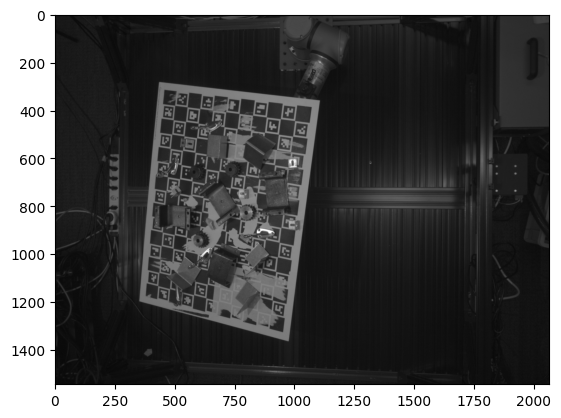

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

part = 'corner_bracket0'
depth_img = ipd_reader.get_depth(scene=30) #ONLY FOR PHOTONEO CAMERA
rbg_img = ipd_reader.get_img(scene=30)
mask_img = ipd_reader.get_mask(scene=30, part=part, instance=0)
plt.imshow(rbg_img)

In [16]:
# Flir and baslet cameras have multiple exposures which can be retrieved by specifying image_type
all_imgs = [ipd_reader.get_img(scene=30, image_type=image_type) for image_type in ipd_reader.camera.images]

2024-09-21 00:09:24 - root - INFO - reader.py - get_img - Opening image from ./datasets/dataset_texturedbg_1/test/000030/000/rgb/000000.png


2024-09-21 00:09:24 - root - INFO - reader.py - get_img - Opening image from ./datasets/dataset_texturedbg_1/test/000030/000/depth/000000.png


In [17]:
ipd_reader.cam_K

array([[2320.26 ,    0.   , 1053.13 ],
       [   0.   , 2320.15 ,  805.064],
       [   0.   ,    0.   ,    1.   ]])

In [18]:
ipd_reader.cam_c2w #The camera coordinate system is as in OpenCV with the camera looking along the Z axis.

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [19]:
# Util to convert to a different available framework
intrinsic_ipd.constants.CameraFramework.convert(
    ipd_reader.cam_c2w, 
    from_camera=intrinsic_ipd.constants.CameraFramework.OPENCV,
    to_camera=intrinsic_ipd.constants.CameraFramework.OPENGL,
    )

array([[ 1.,  0., -0.,  0.],
       [-0., -1.,  0., -0.],
       [ 0.,  0., -1., -0.],
       [ 0.,  0.,  0.,  1.]])

## 4. Utilities

### 4.1 Removing symmetries from poses

In [22]:
part = 'corner_bracket0'
ipd_reader._get_symm_params(part) #NOTE: used for symmetry removal

{'discrete_symm_rots': [array([[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]])],
 'proper_symms': array([[[1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]]]),
 'symmetry_mode': 'full_discrete',
 'continuous_symm_axis': -1,
 'fix_continuous_symm_angles': True,
 'ref_pose': array([[ 1.,  0.,  0.],
        [ 0.,  0., -1.],
        [ 0.,  1.,  0.]])}

In [21]:
# remove symmetries by specifying part
part = 'corner_bracket0'
pose = ipd_reader.o2c.sel(scene=30, part=part, instance=0).data #returns a numpy array
ipd_reader.remove_symmetry(part=part, poses=[pose])

[array([[   0.1998,    0.7808,    0.5919, -209.3239],
        [  -0.5991,    0.5754,   -0.5568, -105.5557],
        [  -0.7753,   -0.2434,    0.5828, 1853.1825],
        [   0.    ,    0.    ,    0.    ,    1.    ]])]

In [12]:
# remove symmetries using the implicit part names specified in xr.DataArray
ipd_reader.remove_symmetry_xarray(ipd_reader.o2c)

<xarray.DataArray (scene: 30, object: 23, transform_major: 4, transform_minor: 4)>
array([[[[   0.1998,    0.7808,    0.5919, -209.3239],
         [  -0.5991,    0.5754,   -0.5568, -105.5557],
         [  -0.7753,   -0.2434,    0.5828, 1853.1825],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

        [[   0.3249,   -0.6633,   -0.6741, -166.4593],
         [  -0.1151,    0.6797,   -0.7244,  220.2536],
         [   0.9387,    0.3129,    0.1445, 1750.2346],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

        [[  -0.5102,    0.7794,   -0.3637, -372.5465],
         [   0.7988,    0.5861,    0.1355,  162.0151],
         [   0.3188,   -0.2214,   -0.9216, 1967.5482],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

        ...,

        [[   0.3161,   -0.8828,   -0.3474, -289.677 ],
         [  -0.9216,   -0.3727,    0.1084,  202.8125],
         [  -0.2252,    0.2859,   -0.9314, 1889.6468],
...
         [   0.7155,    0.697 ,    0.0468,  180.2697],
         [   0.1061,   -0.0423,   -0.9934, 2039.3486],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

        ...,

        [[   0.498 ,   -0.8633,   -0.0821,  -64.1376],
         [  -0.865 ,   -0.5012,    0.0223,  231.4823],
         [  -0.0605,    0.0599,   -0.9964, 1984.3297],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

        [[   0.9744,   -0.2089,    0.0832, -212.1853],
         [   0.2112,    0.9772,   -0.0196,   39.54  ],
         [  -0.0772,    0.0366,    0.9963, 1991.4798],
         [   0.    ,    0.    ,    0.    ,    1.    ]],

        [[   0.0714,    0.9957,    0.0587,  170.0804],
         [  -0.9974,    0.0714,    0.0008,   13.2525],
         [  -0.0033,   -0.0586,    0.9983, 1964.314 ],
         [   0.    ,    0.    ,    0.    ,    1.    ]]]])
Coordinates:
  * scene            (scene) int64 30 31 32 33 34 35 36 ... 53 54 55 56 57 58 59
  * object           (object) MultiIndex
  - part             (object) object 'corner_bracket0' ... 'wraparound_bracket'
  - instance         (object) int64 0 1 2 3 4 0 1 2 3 4 ... 3 0 1 2 3 4 0 1 2 3
  * transform_major  (transform_major) int64 0 1 2 3
  * transform_minor  (transform_minor) int64 0 1 2 3